# Arabic 100k Reviews (Part 2): Classifier

## Overview

This notebook is the second part of the Arabic 100k Reviews classification pipeline. Building on the preprocessing work from Part 1, we now focus on building and evaluating a text classification model to predict sentiment (Positive or Negative) from Arabic reviews. This notebook covers vectorization, model training, evaluation, and interpretation of results, demonstrating a complete end-to-end NLP classification pipeline.

In [1]:
#
# Refer to the README.md for lab setup instructions
#

## Objectives

- Build a text classification model for Arabic sentiment analysis
- Apply vectorization techniques (TF-IDF) to convert preprocessed text into numerical features
- Train and evaluate a machine learning classifier (Logistic Regression)
- Understand model evaluation metrics (accuracy, precision, recall, F1-score, confusion matrix)
- Interpret classification results and analyze model performance
- Recognize the importance of proper train/test splitting and data preprocessing

## Outline

1. **Setup and Imports** - Installing dependencies and importing libraries
2. **Data Loading** - Loading preprocessed data from Part 1
3. **Text Analytics (EDA)** - Analyzing the preprocessed dataset
4. **Vectorization** - Converting text to numerical features using TF-IDF
5. **Model Training** - Training a Logistic Regression classifier
6. **Model Evaluation** - Assessing performance with various metrics
7. **Results Interpretation** - Understanding model predictions and errors

In [1]:
# Standard library imports
import random
from collections import Counter

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:
df_normal = pd.read_csv('ar_reviews_100k_cleaned.tsv', sep='\t')

In [4]:
sample_ids = df_normal.loc[45:50].index
sample_ids

RangeIndex(start=45, stop=51, step=1)

In [5]:
df_normal.loc[sample_ids]

,label,text,num_chars,num_words,text_clean,stemmed_tokens
45,Negative,ضعيف. الانترنت. الفندق,22,3,ضعيف الانترنت الفندق,"['ضعف', 'نرن', 'ندق']"
46,Positive,جيد جدا. شكرا لكم.,18,4,جيد جدا شكرا لكم,"['جيد', 'جدا', 'شكر']"
47,Positive,رأيي في هذا الكتاب و جزئه الاول ما قاله مصطفي ...,115,23,رأيي في هذا الكتاب و جزئه الاول ما قاله مصطفي ...,"['رأي', 'كتب', 'جزئ', 'اول', 'قله', 'صطف', 'حم..."
48,Mixed,حبيت اسلوب الكاتبه كتير وفي جزء كبير روحاني وح...,58,10,حبيت اسلوب الكاتبه كتير وفي جزء كبير روحاني وح...,"['حبت', 'سلب', 'كتب', 'كتر', 'وفي', 'جزء', 'كب..."
49,Mixed,جيد . الفدق جيد. الوقع. الاستقبال مركز الخدمة,45,8,جيد الفدق جيد الوقع الاستقبال مركز الخدمة,"['جيد', 'فدق', 'جيد', 'وقع', 'ركز', 'خدم']"
50,Mixed,تقييمي . . مكتوب من ضمن الخيارات تقديم مشروب م...,102,20,تقييمي مكتوب من ضمن الخيارات تقديم مشروب مجاني...,"['قيم', 'كتب', 'ضمن', 'خير', 'قدم', 'شرب', 'مج..."


## Text Analytics (EDA)

After all of this, let's count the number of unique tokens:

In [6]:
all_tokens = [item for sublist in df_normal['stemmed_tokens'] for item in sublist]
token_counter = Counter(all_tokens)
token_counter.most_common(10)

[("'", 428696),
 (',', 205347),
 (' ', 205347),
 ('ر', 53548),
 ('ل', 48756),
 ('ا', 43960),
 ('م', 37622),
 ('ن', 34172),
 ('ي', 33837),
 ('د', 33724)]

In [7]:

# Split the string tokens directly without ast
df_normal['stemmed_tokens'] = df_normal['stemmed_tokens'].apply(lambda x: x.replace("[", "").replace("]", "").replace("'", "").replace(",", "").split())

all_tokens = [item for sublist in df_normal['stemmed_tokens'] for item in sublist]
token_counter = Counter(all_tokens)
token_counter.most_common(10)

[('كتب', 4412),
 ('جدا', 2839),
 ('ان', 2804),
 ('ندق', 2616),
 ('غرف', 2102),
 ('روي', 2066),
 ('عمل', 1710),
 ('وقع', 1678),
 ('كثر', 1648),
 ('جمل', 1511)]

#### **Student** Exercise

WHAT HAPPENED? WHY ARE WE GETTING THIS OUTPUT?:

```
[("'", 428696),
 (',', 205347),
 (' ', 205347),
 ('ر', 53548),
 ('ل', 48756),
 ('ا', 43960),
 ('م', 37622),
 ('ن', 34172),
 ('ي', 33837),
 ('د', 33724)]
 ```

> Your task is to fix the issue above

How many unique words do we have now?

In [10]:
len(token_counter)

13281

In [12]:
unique_ratio = len(token_counter) / len(all_tokens)
print(f'Unique ratio: {unique_ratio:.2%}')

Unique ratio: 6.20%


Let's find out which words are associated with positive and negative labels, and which aren't.

In [13]:
# Split counts based on labels
counter_positive = Counter([item for sublist in df_normal.loc[df_normal['label'] == 'Positive', 'stemmed_tokens'] for item in sublist])
counter_negative = Counter([item for sublist in df_normal.loc[df_normal['label'] == 'Negative', 'stemmed_tokens'] for item in sublist])
counter_mixed = Counter([item for sublist in df_normal.loc[df_normal['label'] == 'Mixed', 'stemmed_tokens'] for item in sublist])

# Purify each label
## Positive
pure_positive = counter_positive.copy()
pure_positive.subtract(counter_negative)
pure_positive.subtract(counter_mixed)

## Negative
pure_negative = counter_negative.copy()
pure_negative.subtract(counter_positive)
pure_negative.subtract(counter_mixed)

## Neutral
pure_mixed = counter_mixed.copy()
pure_mixed.subtract(counter_positive)
pure_mixed.subtract(counter_negative)

In [14]:
pd.DataFrame(
    pure_positive.most_common(20),
    columns=['token', 'count']
).style.background_gradient(cmap='Greens')

,token,count
0,رئع,450
1,متز,312
2,استثنائي,208
3,هدء,62
4,شكر,52
5,ارع,50
6,بدع,38
7,رقي,34
8,رحة,30
9,عشت,29


In [15]:
pd.DataFrame(
    pure_negative.most_common(20),
    columns=['token', 'count']
).style.background_gradient(cmap='Reds')

,token,count
0,خيب,274
1,سيئ,252
2,ضعف,250
3,امل,214
4,سيء,98
5,نجم,50
6,اسأ,49
7,اسف,44
8,سئ,42
9,اسء,41


In [16]:
# These are the neutral words that are not in the positive or negative
pd.DataFrame(
    pure_mixed.most_common(20),
    columns=['token', 'count']
).style.background_gradient(cmap='Blues')

,token,count
0,رضي,272
1,حسن,45
2,سجن,21
3,عصم,9
4,فنج,9
5,وكن,8
6,تلت,8
7,يثر,7
8,ابس,7
9,ايا,7


In [17]:
df_normal.loc[sample_ids]

,label,text,num_chars,num_words,text_clean,stemmed_tokens
45,Negative,ضعيف. الانترنت. الفندق,22,3,ضعيف الانترنت الفندق,"[ضعف, نرن, ندق]"
46,Positive,جيد جدا. شكرا لكم.,18,4,جيد جدا شكرا لكم,"[جيد, جدا, شكر]"
47,Positive,رأيي في هذا الكتاب و جزئه الاول ما قاله مصطفي ...,115,23,رأيي في هذا الكتاب و جزئه الاول ما قاله مصطفي ...,"[رأي, كتب, جزئ, اول, قله, صطف, حمد, بصر, بعي, ..."
48,Mixed,حبيت اسلوب الكاتبه كتير وفي جزء كبير روحاني وح...,58,10,حبيت اسلوب الكاتبه كتير وفي جزء كبير روحاني وح...,"[حبت, سلب, كتب, كتر, وفي, جزء, كبر, روح, وحب, ..."
49,Mixed,جيد . الفدق جيد. الوقع. الاستقبال مركز الخدمة,45,8,جيد الفدق جيد الوقع الاستقبال مركز الخدمة,"[جيد, فدق, جيد, وقع, ركز, خدم]"
50,Mixed,تقييمي . . مكتوب من ضمن الخيارات تقديم مشروب م...,102,20,تقييمي مكتوب من ضمن الخيارات تقديم مشروب مجاني...,"[قيم, كتب, ضمن, خير, قدم, شرب, مجا, وهذا, حدث,..."


### Introduction to Text Classification

Now that we have cleaned and preprocessed our text data, we can build a **text classifier** that predicts the sentiment (Positive, Negative, or Mixed) of Arabic reviews.

**What is Text Classification?**

Text classification is a supervised machine learning task where we:
1. **Extract features** from text (convert text to numbers)
2. **Train a model** to learn patterns between features and labels
3. **Predict** the class of new, unseen text

**Why use word counts?**

After cleaning and preprocessing, we have a list of tokens (words) for each review. One simple but effective approach is to:
- Count how many times each word appears in each document
- Use these counts as features for our classifier
- This is called **Bag of Words (BoW)** representation

**The Bag of Words Model:**

The Bag of Words model represents text as a vector of word counts, ignoring word order and grammar. For example:

- Review 1: "ممتاز رائع" → `{"ممتاز": 1, "رائع": 1}`
- Review 2: "ممتاز ممتاز سيء" → `{"ممتاز": 2, "رائع": 0, "سيء": 1}`

This creates a feature matrix where:
- Each row = one review
- Each column = one unique word in the vocabulary
- Each cell = count of that word in that review

**Why this works:**

From our EDA, we saw that certain words are more associated with positive reviews (e.g., "ممتاز", "رائع") and others with negative reviews (e.g., "سيء", "ضعيف"). A classifier can learn these patterns from the word counts.

### Step 1: Prepare Text Data for Feature Extraction

Our `stemmed_tokens` column contains lists of tokens. To use scikit-learn's `CountVectorizer`, we need to convert these token lists back into text strings (space-separated words).

**Why convert back to strings?**

- `CountVectorizer` expects text input (strings)
- It will handle tokenization internally, but since we've already cleaned and stemmed our text, we want to use our preprocessed tokens
- We'll join the tokens with spaces to create clean text strings

In [18]:
# Convert token lists back to space-separated strings
# This allows CountVectorizer to work with our preprocessed tokens
df_normal['text_processed'] = df_normal['stemmed_tokens'].apply(lambda tokens: ' '.join(tokens))

# Display a sample to verify
print("Original text:")
print(df_normal.loc[sample_ids[0], 'text'])
print("\nCleaned and processed text:")
print(df_normal.loc[sample_ids[0], 'text_processed'])
print("\nTokens used:")
print(df_normal.loc[sample_ids[0], 'stemmed_tokens'][:10])  # Show first 10 tokens

Original text:
ضعيف. الانترنت. الفندق

Cleaned and processed text:
ضعف نرن ندق

Tokens used:
['ضعف', 'نرن', 'ندق']


### Step 2: Create Word Count Features

We'll use scikit-learn's `CountVectorizer` to convert our processed text into a matrix of word counts.

**Key parameters:**
- `max_features`: Limit vocabulary size to the most frequent N words (reduces dimensionality)
- `min_df`: Ignore words that appear in fewer than N documents (removes rare words)
- `max_df`: Ignore words that appear in more than N% of documents (removes common words that appear everywhere)

**Why limit features?**
- Reduces memory usage
- Speeds up training
- Can improve generalization by focusing on meaningful words

In [19]:
# Create CountVectorizer (Bag of Words)
# We use max_features to limit vocabulary size for efficiency
# min_df=2 means words must appear in at least 2 documents
vectorizer = CountVectorizer(
    max_features=5000,  # Use top 5000 most frequent words
    min_df=2,           # Word must appear in at least 2 documents
    max_df=0.95         # Ignore words that appear in >95% of documents
)

# Transform text to word count matrix
# This creates a sparse matrix where each row is a review and each column is a word
X = vectorizer.fit_transform(df_normal['text_processed'])
y = df_normal['label'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Number of reviews: {X.shape[0]}")
print(f"Number of features (words): {X.shape[1]}")
print(f"Labels: {np.unique(y)}")

Feature matrix shape: (9005, 5000)
Number of reviews: 9005
Number of features (words): 5000
Labels: ['Mixed' 'Negative' 'Positive']


**Understanding the Feature Matrix:**

The `X` matrix is sparse (mostly zeros) because:
- Each review contains only a small subset of all possible words
- Most words don't appear in most reviews
- This is normal and expected for text data

Let's visualize what the feature matrix looks like:

In [20]:
# Convert sparse matrix to dense for visualization (only for small samples!)
# Note: For large datasets, keep it sparse to save memory
X_sample = X[:5].toarray()

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for better visualization
df_features = pd.DataFrame(
    X_sample,
    columns=feature_names,
    index=[f"Review {i+1}" for i in range(5)]
)

# Show only columns (words) that appear in these 5 reviews
non_zero_cols = df_features.columns[df_features.sum() > 0]
print(f"Showing {len(non_zero_cols)} words that appear in the first 5 reviews:")
display(df_features[non_zero_cols[:20]])  # Show first 20 words

Showing 115 words that appear in the first 5 reviews:


,أرع,ابد,اثب,احا,ارع,اكد,الا,الل,ان,انا,انه,او,اول,بحق,بده,برع,بلس,تتر,تطع,تعدد
Review 1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
Review 2,1,0,1,1,2,1,1,1,0,1,3,0,0,1,0,1,0,0,0,0
Review 3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Review 4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0
Review 5,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1


### Step 3: Split Data into Training and Testing Sets

**Why split the data?**

We need to:
1. **Train** the model on one portion of data
2. **Test** the model on unseen data to evaluate its performance
3. **Prevent overfitting** - ensure the model generalizes to new data

**Important:** We split AFTER preprocessing to avoid data leakage (information from test set influencing training).

In [21]:
from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% testing
# stratify=y ensures same class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y  # Maintain class balance
)

print(f"Training set: {X_train.shape[0]} reviews")
print(f"Test set: {X_test.shape[0]} reviews")
print("\nTraining label distribution:")
print(pd.Series(y_train).value_counts())
print("\nTest label distribution:")
print(pd.Series(y_test).value_counts())

Training set: 7204 reviews
Test set: 1801 reviews

Training label distribution:
Positive    2407
Mixed       2402
Negative    2395
Name: count, dtype: int64

Test label distribution:
Positive    602
Mixed       601
Negative    598
Name: count, dtype: int64


### Step 4: Train a Classifier

We'll use a **Logistic Regression** classifier, which is:
- **Fast** and efficient for text classification
- **Well-suited** for count-based features (like our word counts)
- **Simple** to understand and interpret
- **Effective** for text classification tasks
- **Provides probability estimates** for each class

**How Logistic Regression works (simplified):**
1. Learns weights for each feature (word) that indicate its importance for each class
2. Uses a logistic function to convert weighted sums into probabilities
3. Predicts the class with highest probability

Logistic Regression is a linear classifier that works well with sparse, high-dimensional text features!

In [22]:
# Create and train the classifier
# max_iter=1000 ensures convergence for large datasets
classifier = LogisticRegression(max_iter=1000, random_state=SEED)
classifier.fit(X_train, y_train)

print("Classifier trained successfully!")
print(f"Number of features learned: {classifier.coef_.shape[1]}")

Classifier trained successfully!
Number of features learned: 5000


### Step 5: Evaluate the Classifier

Now let's evaluate how well our classifier performs on the test set. We'll use several metrics:

- **Accuracy**: Overall percentage of correct predictions
- **Precision**: Of all predictions for a class, how many were correct?
- **Recall**: Of all actual instances of a class, how many did we find?
- **F1-Score**: Harmonic mean of precision and recall (balances both)

In [23]:
# Make predictions on test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2%}")
print("\n" + "="*60)
print("Detailed Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred))

Test Accuracy: 59.13%

Detailed Classification Report:
              precision    recall  f1-score   support

       Mixed       0.49      0.48      0.48       601
    Negative       0.65      0.65      0.65       598
    Positive       0.63      0.65      0.64       602

    accuracy                           0.59      1801
   macro avg       0.59      0.59      0.59      1801
weighted avg       0.59      0.59      0.59      1801



**Understanding the Classification Report:**

- **Precision**: When the model predicts a class, how often is it correct?
  - High precision = few false positives
  
- **Recall**: How many of the actual instances of a class did we catch?
  - High recall = few false negatives
  
- **F1-Score**: Balances precision and recall
  - Useful when you need a single metric
  
- **Support**: Number of actual instances of each class in the test set

Confusion Matrix:
(Rows = Actual, Columns = Predicted)


,Predicted Mixed,Predicted Negative,Predicted Positive
Actual Mixed,286,149,166
Actual Negative,144,388,66
Actual Positive,155,56,391


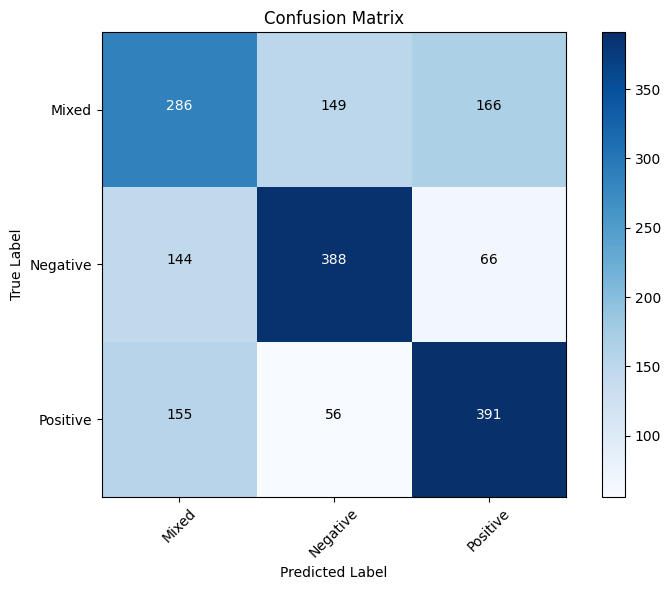

In [24]:
# Create confusion matrix for visualization
cm = confusion_matrix(y_test, y_pred)

# Display as DataFrame for better readability
cm_df = pd.DataFrame(
    cm,
    index=[f"Actual {label}" for label in classifier.classes_],
    columns=[f"Predicted {label}" for label in classifier.classes_]
)

print("Confusion Matrix:")
print("(Rows = Actual, Columns = Predicted)")
display(cm_df)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classifier.classes_))
plt.xticks(tick_marks, classifier.classes_, rotation=45)
plt.yticks(tick_marks, classifier.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

**Reading the Confusion Matrix:**

- **Diagonal elements** (top-left to bottom-right): Correct predictions
- **Off-diagonal elements**: Misclassifications
  - Example: If "Actual Negative" row has a number in "Predicted Positive" column, those are negative reviews incorrectly classified as positive

The confusion matrix helps us understand:
- Which classes are confused with each other
- Whether errors are balanced or biased toward certain classes

### Step 6: Analyze Important Features

Let's see which words are most important for each class. This helps us understand what the model learned and provides interpretability.

In [28]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Get coefficients for each class
# Higher values = more indicative of that class
coefficients = classifier.coef_

# Create DataFrame showing top words for each class
top_words_per_class = {}
for idx, class_label in enumerate(classifier.classes_):
    # Get indices of top words for this class
    top_indices = np.argsort(coefficients[idx])[-20:][::-1]  # Top 20 words
    top_words = [(feature_names[i], coefficients[idx][i]) for i in top_indices]
    top_words_per_class[class_label] = top_words

# Display results
for class_label, words in top_words_per_class.items():
    print(f"\n{'='*60}")
    print(f"Top 20 words for class: {class_label}")
    print(f"{'='*60}")
    #df_top = pd.DataFrame(words, columns=['Word', 'Coefficient']).style.background_gradient(cmap='Greens')
    df_top = pd.DataFrame(words, columns=['Word', 'Coefficient']).set_index('Word').T
    #display(df_top.T)
    display(df_top.style.background_gradient(cmap='Greens',axis=1))


Top 20 words for class: Mixed


Word,رضي,يقف,حسن,سلي,وبه,لمب,بغى,شلل,صلى,تقطع,ظل,دخر,خيف,محل,أخلاق,جنة,تدع,ليا,لمى,اسس
Coefficient,2.401846,1.327786,1.322000,1.158635,1.150787,1.068303,1.053937,1.006379,0.993309,0.993267,0.977374,0.939662,0.936466,0.933216,0.925178,0.916268,0.908854,0.898865,0.889834,0.883600



Top 20 words for class: Negative


Word,خيب,ضعف,سطح,سي,ملة,اسء,اسأ,يظل,ضيع,طور,غلف,يزد,حبط,وغر,ارى,هبل,لغي,وسء,عزب,ترق
Coefficient,2.710713,1.514447,1.431172,1.336642,1.321152,1.250449,1.195334,1.175760,1.147931,1.139992,1.133693,1.080817,1.029206,1.021139,1.015013,1.010683,1.007659,1.006144,0.982186,0.973246



Top 20 words for class: Positive


Word,استثنائي,ارع,رئع,تحف,متز,روض,ثقة,روع,هدء,بهو,ذهل,عبقر,دمع,بدع,اعط,رحة,صرى,انك,غني,تقر
Coefficient,3.210130,1.638170,1.393701,1.331849,1.225206,1.205662,1.161324,1.128424,1.059039,1.034934,1.031707,1.030182,1.009437,1.005152,0.989739,0.989019,0.984464,0.973246,0.963081,0.961195


**Interpreting Feature Importance:**

The coefficients tell us how strongly each word is associated with each class:
- **Higher coefficient** = word is more indicative of that class
- **Lower (more negative) coefficient** = word is less indicative of that class
- Words with high coefficients for "Positive" are likely positive sentiment words
- Words with high coefficients for "Negative" are likely negative sentiment words

**Compare with EDA results:** Do these top words match the words we found in our earlier EDA analysis? This validates that the model learned meaningful patterns!

### Step 7: Test on Sample Reviews

Let's test our classifier on some example reviews to see it in action:

Sample Predictions:


,Review #,Snippet,Actual Label,Predicted Label,Confidence,P(Mixed),P(Negative),P(Positive)
0,973,كتاب دمو خفيف ، ضحكت كتير خاصة ع القط مرسي لانه يشبه قطي ههه,Mixed,Negative,72.75%,20.43%,72.75%,6.82%
1,1747,احببت الحب وتلك الاماني الجميله ورب خرافه خير من الف واقع .. الا ان في النهايه ش...,Mixed,Positive,92.22%,7.55%,0.23%,92.22%
2,785,لم يعجبني . الموقع وسعة المواقف. رائحة الدخان منتشرة بممرات الفندق .. وما كتب في...,Mixed,Mixed,65.07%,65.07%,28.63%,6.30%
3,162,بوكر : . كنت مستغرب جدا ان إذاي رواية الفيل الأزرق ضمن الفائمة القصيرة. بس لما ر...,Negative,Positive,51.28%,33.35%,15.38%,51.28%
4,1272,خدمة . . المدة في توفير الشبكة سيء جداوكمية توفير البيانات قليل جدا جدا. وحتى طل...,Positive,Mixed,59.65%,59.65%,10.03%,30.32%


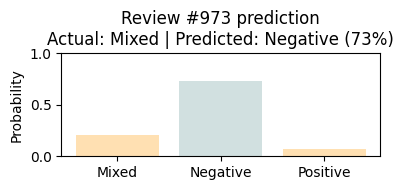

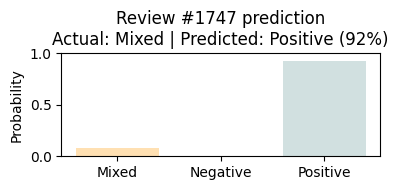

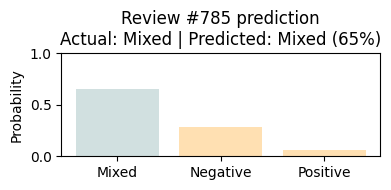

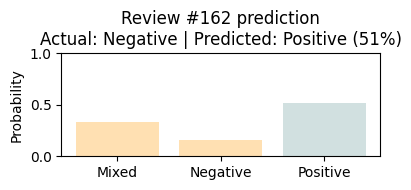

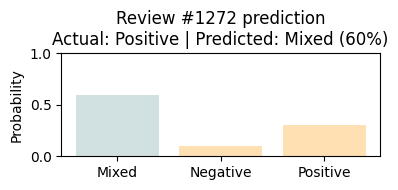

In [29]:
# Get test indices in the original dataframe
# train_test_split maintains order, so we need to track which rows went to test set
_, test_indices_original = train_test_split(
    df_normal.index,
    test_size=0.2,
    random_state=SEED,
    stratify=df_normal['label']
)

# Select a few random test examples
np.random.seed(SEED)
# FIX: For sparse matrices, use shape[0] instead of len()
sample_test_indices = np.random.choice(X_test.shape[0], size=5, replace=False)

print("Sample Predictions:")
print("="*80)

# For a more visual display, let's build a table of predictions and use color to show confidence

viz_rows = []
for test_idx in sample_test_indices:
    original_df_idx = test_indices_original[test_idx]
    text_snippet = df_normal.loc[original_df_idx, 'text'][:80] + ("..." if len(df_normal.loc[original_df_idx, 'text']) > 80 else "")
    actual = y_test[test_idx]
    prediction = classifier.predict(X_test[test_idx:test_idx+1])[0]
    probs = classifier.predict_proba(X_test[test_idx:test_idx+1])[0]
    confidence = probs[classifier.classes_.tolist().index(prediction)]
    viz_rows.append({
        "Review #": test_idx,
        "Snippet": text_snippet,
        "Actual Label": actual,
        "Predicted Label": prediction,
        "Confidence": confidence,
        **{f"P({cls})": p for cls, p in zip(classifier.classes_, probs)}
    })

viz_df = pd.DataFrame(viz_rows)
# True-match in green, wrong in red
def highlight_prediction(row):
    color = ""
    if row['Actual Label'] == row['Predicted Label']:
        color = "background-color: #d4f4dd"  # light green
    else:
        color = "background-color: #f4cccc"  # light red
    return [color]*len(row)
# Display styled table, coloring accuracy and using a confidence gradient on "Confidence"
viz_df_styled = (viz_df.style
    .apply(highlight_prediction, axis=1)
    .background_gradient(subset=['Confidence'], cmap='Blues')
    .format({col: "{:.2%}" for col in ['Confidence'] + [f"P({cls})" for cls in classifier.classes_]})
)
display(viz_df_styled)

# Also, show barplots of the predicted probability for each review
for idx, row in viz_df.iterrows():
    plt.figure(figsize=(4,2))
    plt.bar(classifier.classes_, [row[f"P({cls})"] for cls in classifier.classes_], color=['#d1e0e0' if row['Predicted Label']==cls else '#ffe0b2' for cls in classifier.classes_])
    plt.title(f"Review #{row['Review #']} prediction\nActual: {row['Actual Label']} | Predicted: {row['Predicted Label']} ({row['Confidence']:.0%})")
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

### Summary: What We Learned

**Key Takeaways:**

- **Simple approaches work**: Word counts (Bag of Words) can be effective for text classification
- **Preprocessing matters**: The cleaning, normalization, and stemming we did earlier improved our features
- **Interpretability**: We can see which words drive predictions, making the model explainable
- **Evaluation is crucial**: Always test on unseen data to measure real-world performance

**Next Steps (for future exploration):**

- Try **TF-IDF** instead of raw counts (weights words by importance)
- Experiment with different classifiers (SVM, Random Forest, etc.)
- Use **word embeddings** (like Word2Vec or pre-trained embeddings) for richer features
- Fine-tune **transformer models** (like BERT) for state-of-the-art performance

---

**Remember**: This is a foundational approach. Modern NLP often uses more sophisticated methods, but understanding word counts and simple classifiers is essential for building intuition about how text classification works!